# EMNIST

EMNIST es una extensión a MNIST donde involucra varios *datasets*, incluyendo la clasificación de caracteres alfabéticos. Es un problema intrínsecamente difícil, los mejores modelos no llegan a 96% según https://paperswithcode.com/sota/image-classification-on-emnist-letters. Además, es un problema práctico, puesto que es importante poder leer manuscritos a mano. Vamos a crear un modelo que pueda resolver, aunque no llegue al 96%.


In [243]:
from keras.utils import to_categorical
import keras
from keras import layers
from scipy import io as spio
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.callbacks import EarlyStopping

# Se agrega el _ para ignorar siempre el label 0 ya que no se usa dentro de este dataset
letters = "_ABCDEFGHIJKLMNOPQRSTUVWXYZ"


Cargamos el conjunto de datos, de la siguiente forma.

In [189]:
emnist = spio.loadmat('./datasets/emnist/emnist-letters.mat')

X_train = emnist['dataset'][0][0][0][0][0][0]
X_train = X_train.astype('float32')


y_train = emnist["dataset"][0][0][0][0][0][1]

X_test = emnist["dataset"][0][0][1][0][0][0]
X_test = X_test.astype('float32')

y_test = emnist["dataset"][0][0][1][0][0][1]

X_train = X_train.reshape(124800, 28, 28, 1)
X_test = X_test.reshape(20800, 28, 28, 1)

X_train = X_train / 255.0
X_test = X_test / 255.0

#Se tienen que rotar por como estan cargadas dentro del dataset
rotated_X_train = np.zeros_like(X_train)
rotated_X_test = np.zeros_like(X_test)
for i in range(X_train.shape[0]):
    rotated_X_train[i] = np.fliplr(np.rot90(X_train[i], k=3))

for i in range(X_test.shape[0]):
    rotated_X_test[i] = np.fliplr(np.rot90(X_test[i], k=3))

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Ahora visualizamos los datos.

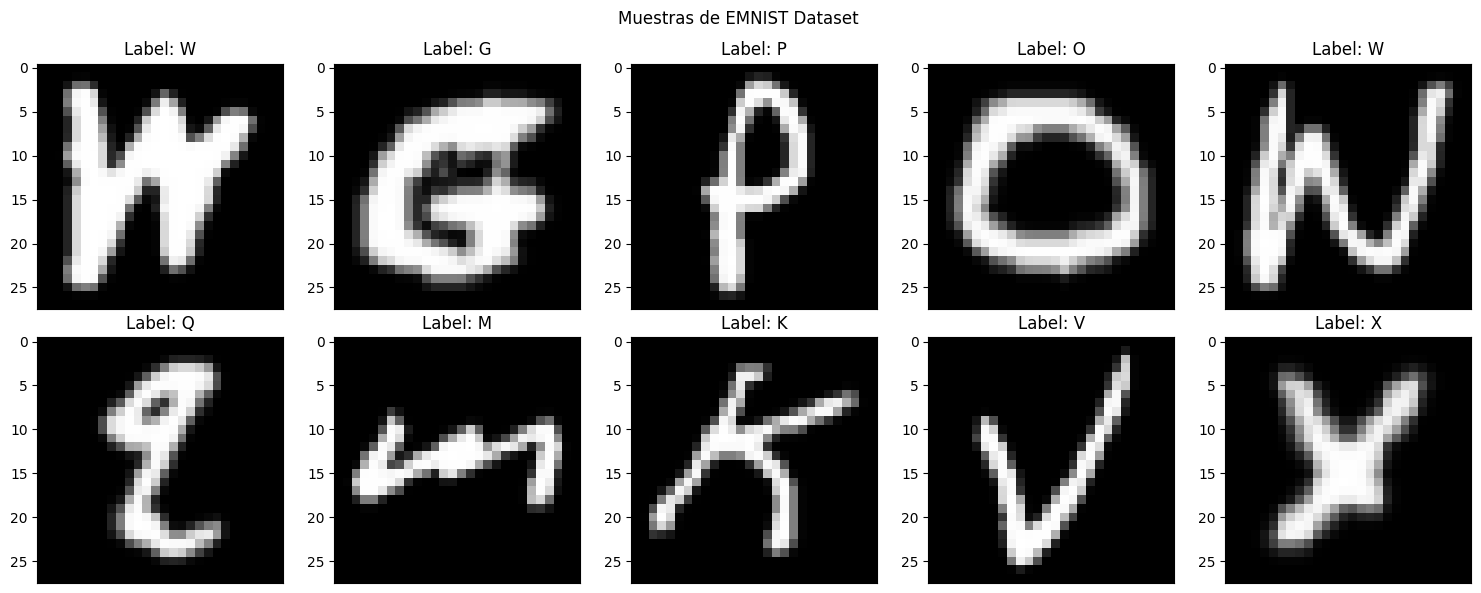

In [242]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(rotated_X_train[i, :, :, 0], cmap=plt.get_cmap('gray'))
    arg_max_label = np.argmax(y_train[i])
    title = f"Label: {letters[arg_max_label]}"
    ax.set_title(title)
    ax.get_xaxis().set_visible(False)
fig.suptitle("Muestras de EMNIST Dataset ")
plt.tight_layout()
plt.show()


In [85]:
model = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(len(y_train[0]), activation="softmax"),
    ]
)

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 26, 26, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 24, 24, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 22, 22, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │     1,982,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 27)             │         3,483 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,135,003 (8.14 MB)

 Trainable params: 2,135,003 (8.14 MB)

 Non-trainable params: 0 (0.00 B)

In [86]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [187]:
results = model.fit(
    rotated_X_train,
    y_train,
    batch_size=128,
    epochs=50,
    callbacks=[early_stop],
    validation_data=(X_test, y_test))

Epoch 1/50
975/975 ━━━━━━━━━━━━━━━━━━━━ 174s 178ms/step - accuracy: 0.8217 - loss: 0.6422 - val_accuracy: 0.1868 - val_loss: 6.4880
Epoch 2/50
975/975 ━━━━━━━━━━━━━━━━━━━━ 169s 173ms/step - accuracy: 0.9468 - loss: 0.1537 - val_accuracy: 0.1877 - val_loss: 6.5688
Epoch 3/50
975/975 ━━━━━━━━━━━━━━━━━━━━ 176s 181ms/step - accuracy: 0.9585 - loss: 0.1143 - val_accuracy: 0.1796 - val_loss: 7.7847
Epoch 4/50
975/975 ━━━━━━━━━━━━━━━━━━━━ 177s 181ms/step - accuracy: 0.9654 - loss: 0.0910 - val_accuracy: 0.1781 - val_loss: 8.4623
Epoch 5/50
975/975 ━━━━━━━━━━━━━━━━━━━━ 179s 184ms/step - accuracy: 0.9713 - loss: 0.0719 - val_accuracy: 0.1718 - val_loss: 10.7239
Epoch 6/50
975/975 ━━━━━━━━━━━━━━━━━━━━ 177s 181ms/step - accuracy: 0.9748 - loss: 0.0606 - val_accuracy: 0.1802 - val_loss: 11.1072


In [191]:
score = model.evaluate(rotated_X_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

650/650 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9290 - loss: 0.2203
Test loss: 0.20710378885269165
Test accuracy: 0.9331250190734863


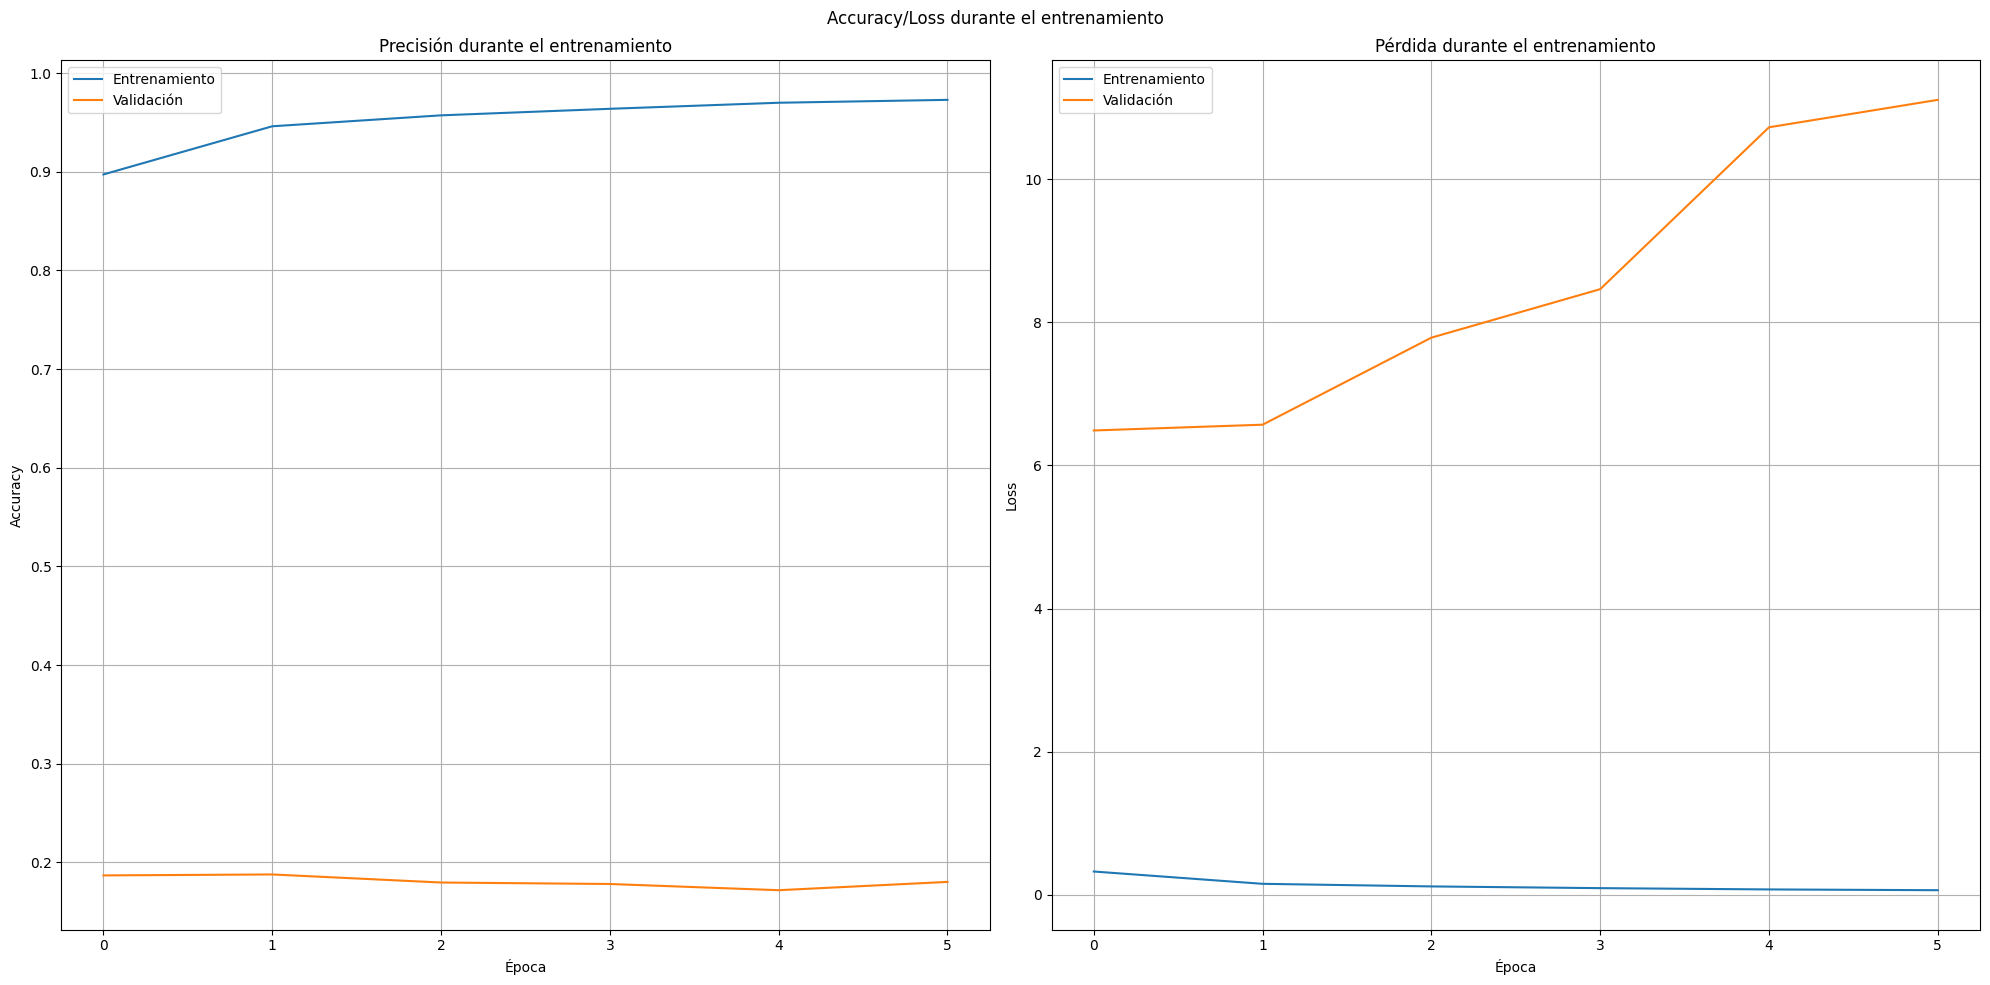

In [241]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
# add accuracy related metrics
axes[0].plot(results.history['accuracy'], label='Entrenamiento')
axes[0].plot(results.history['val_accuracy'], label='Validación')
axes[0].set_title('Precisión durante el entrenamiento')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(results.history['loss'], label='Entrenamiento')
axes[1].plot(results.history['val_loss'], label='Validación')
axes[1].set_title('Pérdida durante el entrenamiento')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

fig.suptitle("Accuracy/Loss durante el entrenamiento")
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


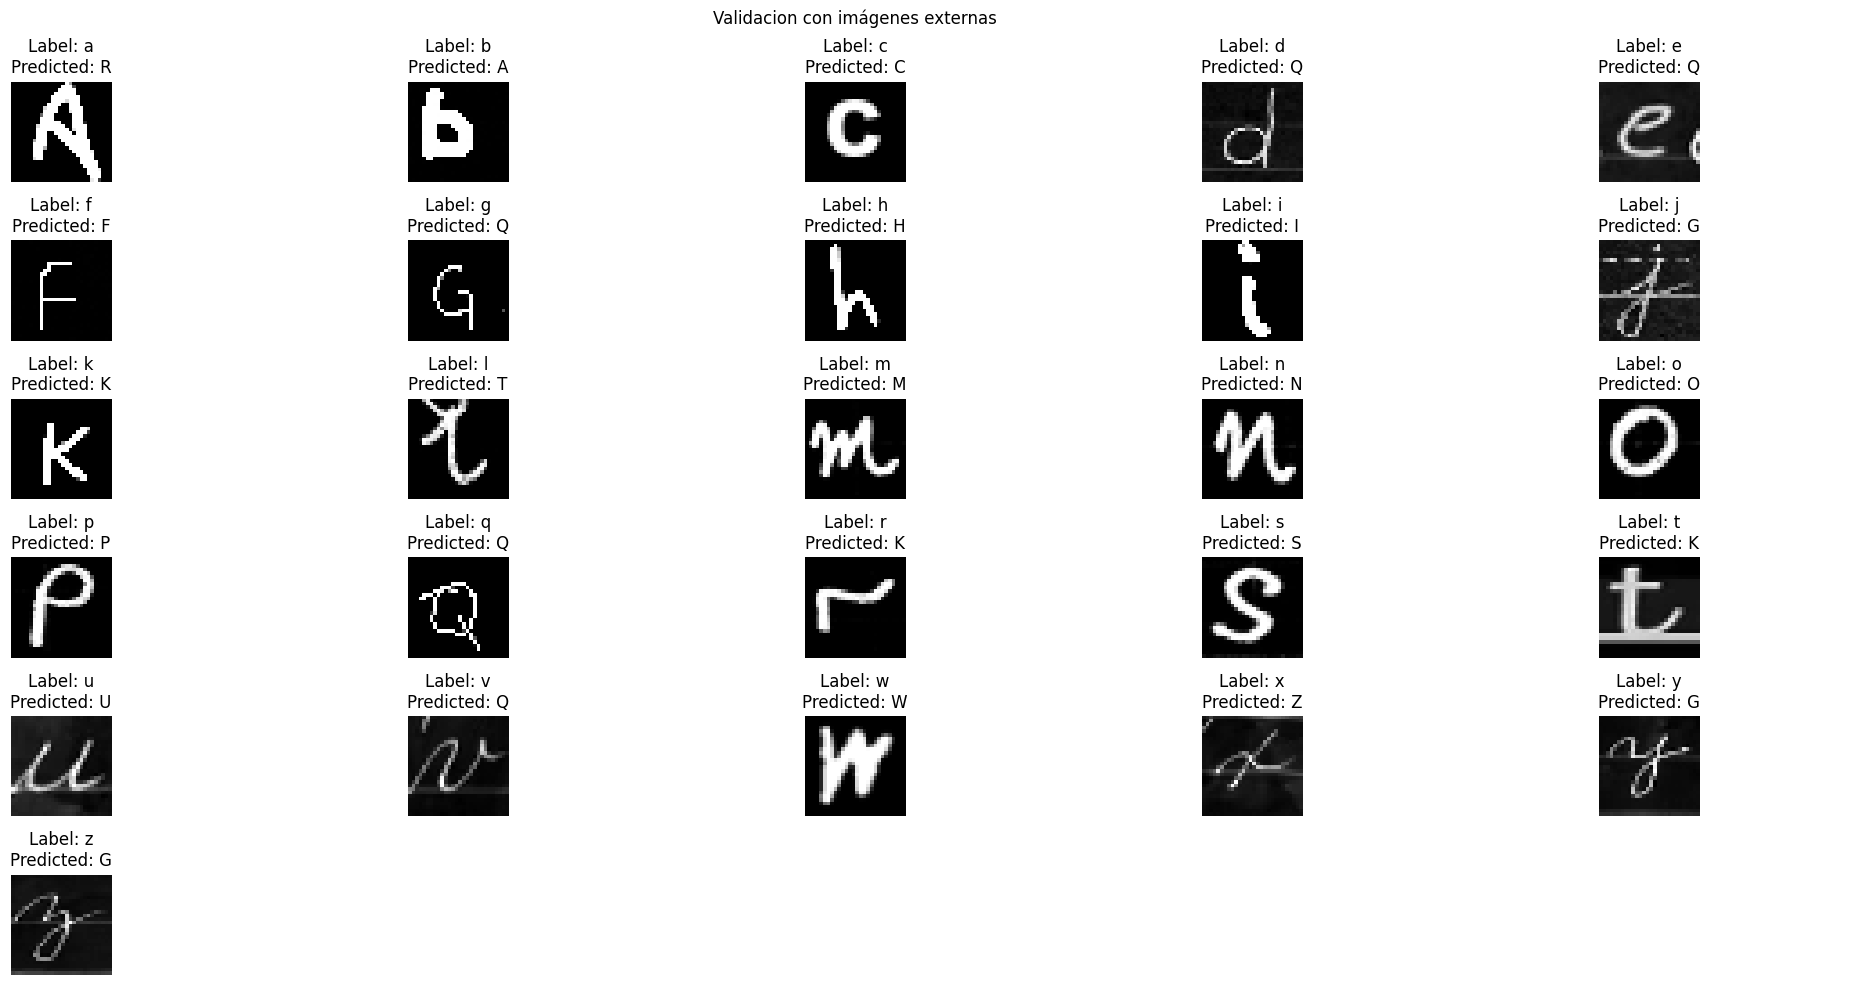

In [248]:
sample_letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
fig, axes = plt.subplots(6, 5, figsize=(20, 10))
predicted_values = []
expected_values = []
for i, ax in enumerate(axes.flatten()):
    if i < len(sample_letters):
        test_img = cv2.imread(f"./datasets/emnist/{sample_letters[i]}_letter.png", cv2.IMREAD_COLOR)
        test_img = cv2.resize(test_img, (28, 28))
        test_img = cv2.bitwise_not(test_img)
        test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
        test_img = test_img / 255.0
        ax.imshow(test_img, cmap=plt.get_cmap('gray'))

        test_img = np.resize(test_img, (1, 28, 28, 1))
        prediction = model.predict(test_img)

        arg_max_label = np.argmax(prediction)
        title = f"Label: {sample_letters[i]}\nPredicted: {letters[arg_max_label]}"

        predicted_values.append(arg_max_label)
        expected_values.append(i)
        ax.set_title(title)
    ax.axis('off')
    test_img = None

fig.suptitle("Validacion con imágenes externas")
plt.tight_layout()
plt.show()

/home/jresendiz/Documents/Personal/CIC_AIDiploma2025/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
/home/jresendiz/Documents/Personal/CIC_AIDiploma2025/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(y_pred, input_name="y_pred")
/home/jresendiz/Documents/Personal/CIC_AIDiploma2025/.venv/lib/python3.12/site-packages/sklearn/utils/multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)
/home/jresendiz/Documents/Personal/CIC_AIDiploma2025/.venv/lib/python3.12/site-packages/sklearn/utils/multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of

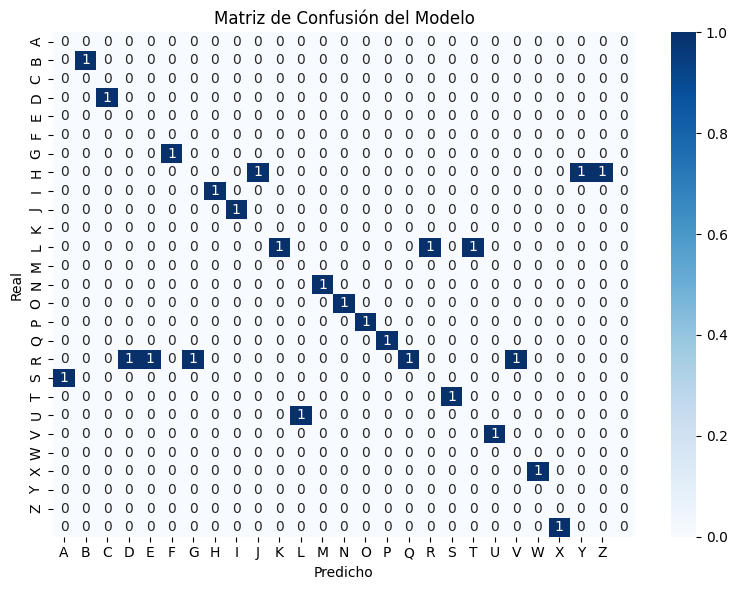

In [254]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(predicted_values, expected_values)
plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=letters[1:], yticklabels=letters[1:])

plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de Confusión del Modelo')
plt.tight_layout()
plt.show()